## Setup

In [1]:
import numpy as np
import torch

import torch.multiprocessing as mp
from backend.cli import base_args, build_other_grabs

from backend.job_iterator import main as run_job_iterator
from backend.utils import ensure_torch

import os, sys

In [ ]:
## All args should be set here

args = base_args() #default args

# Set any args that we want to differ
args.ONLINE = False
args.ONLYTHRESHOLDS = False
args.N_TRAIN=4000
args.N_TEST=1000
args.N_TOT = args.N_TEST+args.N_TRAIN
args.CLASSES = [[0], [6]]
args.NORMALIZED = True
args.NUM_TRIALS = 2
args.LR = 1e-1
args.MAX_ITER = 1e2
args.N_SAMPLES = [16]
args.GAMMA = [0.1, 1, 10]
args.other_model_grabs = {"ENTK": "empirical_ntk"}
args.other_model_gram = {"ENTK": {"call_with_model": True}}

iterators = [args.N_SAMPLES, range(args.NUM_TRIALS), args.GAMMA]
iterator_names = ["ntrain", "trial", "GAMMA"]

## Code execution

In [3]:
## Dataset
from ImageData import ImageData, preprocess
PIXEL_NORMALIZED =  False # Don't normalize pixels, normalize samples
classes = args.CLASSES if args.datasethps is not None else args.datasethps.get('classes', None)
normalized = args.NORMALIZED if args.datasethps is not None else args.datasethps.get('normalized', True)

if classes is not None:
	imdata = ImageData('cifar10', "../data", classes=classes, onehot=len(classes)!=2)
else:
	imdata = ImageData('cifar10', "../data", classes=classes, onehot=False)
X_train, y_train = imdata.get_dataset(args.N_TRAIN, get='train')
X_train = preprocess(X_train, center=True, greyscale=True, normalize=PIXEL_NORMALIZED)
X_test, y_test = imdata.get_dataset(args.N_TEST, get='test')
X_test = preprocess(X_test, center=True, greyscale=True, normalize=PIXEL_NORMALIZED)
X_train, y_train, X_test, y_test = map(ensure_torch, (X_train, y_train, X_test, y_test))
y_train = y_train.squeeze()
y_test = y_test.squeeze()
X_train, y_train, X_test, y_test = [t/torch.linalg.norm(t) for t in (X_train, y_train, X_test, y_test)] if normalized else (X_train, y_train, X_test, y_test)
if normalized:
	X_train *= args.N_TRAIN**(0.5); X_test *= args.N_TEST**(0.5)
	y_train *= args.N_TRAIN**(0.5); y_test *= args.N_TEST**(0.5)
X_full = torch.cat((X_train, X_test), dim=0)
y_full = torch.cat((y_train, y_test), dim=0)
data_eigvals = torch.linalg.svdvals(X_full)**2
data_eigvals /= data_eigvals.sum()

U, lambdas, Vt = torch.linalg.svd(X_full, full_matrices=False)
dim = X_full.shape[1]

bfn_config = dict(X_total = X_full, y_total = y_full, bfn_name="general_batch_fn")
del X_full, y_full

Files already downloaded and verified
Files already downloaded and verified


In [4]:
global_config = dict(DEPTH=args.DEPTH, WIDTH=args.WIDTH, LR=args.LR, GAMMA=args.GAMMA,
	EMA_SMOOTHER=args.EMA_SMOOTHER, MAX_ITER=args.MAX_ITER,
	LOSS_CHECKPOINTS=args.LOSS_CHECKPOINTS, N_TEST=args.N_TEST,
	SEED=args.SEED, ONLYTHRESHOLDS=args.ONLYTHRESHOLDS, DIM=dim,
	ONLINE=args.ONLINE, VERBOSE=args.VERBOSE
	)

grabs = build_other_grabs(args.other_model_grabs, default_source=args.W_source, concat_outside=args.concat_outside,
	per_alias_gram=args.other_model_gram, per_alias_kwargs=args.other_model_kwargs,)
global_config.update({"otherreturns": grabs})

In [5]:
mp.set_start_method("spawn", force=True)

result = run_job_iterator(iterators, iterator_names, global_config, bfn_config=bfn_config)
torch.cuda.empty_cache()

Runs:   0%|          | 0/6 [00:00<?, ?it/s]

Runs:  17%|█▋        | 1/6 [00:04<00:20,  4.17s/it]

[ERROR] (64, 0, 0.1): OutOfMemoryError('CUDA out of memory. Tried to allocate 22.01 GiB. GPU \x05 has a total capacity of 23.69 GiB of which 20.30 GiB is free. Process 2890454 has 402.00 MiB memory in use. Process 2892588 has 402.00 MiB memory in use. Process 2896628 has 402.00 MiB memory in use. Process 3054225 has 402.00 MiB memory in use. Process 3056397 has 402.00 MiB memory in use. Process 1646773 has 1.41 GiB memory in use. Of the allocated memory 1.06 GiB is allocated by PyTorch, and 43.95 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)')


Runs:  33%|███▎      | 2/6 [00:05<00:09,  2.36s/it]

[ERROR] (64, 0, 10): OutOfMemoryError('CUDA out of memory. Tried to allocate 22.01 GiB. GPU ')
[ERROR] (64, 0, 1): OutOfMemoryError('CUDA out of memory. Tried to allocate 22.01 GiB. GPU \x01 has a total capacity of 23.69 GiB of which 19.90 GiB is free. Process 2890450 has 402.00 MiB memory in use. Process 2892584 has 402.00 MiB memory in use. Process 2894586 has 402.00 MiB memory in use. Process 2896624 has 402.00 MiB memory in use. Process 3054221 has 402.00 MiB memory in use. Process 3056393 has 402.00 MiB memory in use. Process 1646769 has 1.41 GiB memory in use. Of the allocated memory 1.06 GiB is allocated by PyTorch, and 43.95 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)')


Runs: 100%|██████████| 6/6 [00:05<00:00,  1.07it/s]

[ERROR] (64, 1, 0.1): OutOfMemoryError('CUDA out of memory. Tried to allocate 22.01 GiB. GPU \x03 has a total capacity of 23.69 GiB of which 19.90 GiB is free. Process 2890452 has 402.00 MiB memory in use. Process 2892586 has 402.00 MiB memory in use. Process 2894588 has 402.00 MiB memory in use. Process 2896626 has 402.00 MiB memory in use. Process 3054223 has 402.00 MiB memory in use. Process 3056395 has 402.00 MiB memory in use. Process 1646771 has 1.41 GiB memory in use. Of the allocated memory 1.06 GiB is allocated by PyTorch, and 43.95 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)')
[ERROR] (64, 1, 1): OutOfMemoryError('CUDA out of memory. Tried to allocate 22.01 GiB. GPU \x07 has a total capacity of 23.69 GiB of which 19.90 GiB is free. Proce

## Analyzing results

In [6]:
from ExptTrace import ExptTrace
et_losses = ExptTrace.deserialize(result['losses'])

In [39]:
result

{'jobs': [(1024, 0, 0.1),
  (1024, 0, 1),
  (1024, 0, 10),
  (1024, 1, 0.1),
  (1024, 1, 1),
  (1024, 1, 10)],
 'var_axes': ['ntrain', 'trial', 'GAMMA'],
 'losses': {'var_names': ['ntrain', 'trial', 'GAMMA'],
  'config2outcome': {(1024, 0, '1'): 0.2262819291268704,
   (1024, 0, '0.1'): 0.7155101857511184,
   (1024, 0, '10'): 0.21559912779635845,
   (1024, 1, '10'): 0.19124262490772145,
   (1024, 1, '0.1'): 0.7521635412810457,
   (1024, 1, '1'): 0.23713462024391002},
  'outcome_shape': ()},
 'timekeys': {'var_names': ['ntrain', 'trial', 'GAMMA'],
  'config2outcome': {(1024, 0, '1'): array([0., 0.]),
   (1024, 0, '0.1'): array([0., 0.]),
   (1024, 0, '10'): array([0., 0.]),
   (1024, 1, '10'): array([0., 0.]),
   (1024, 1, '0.1'): array([0., 0.]),
   (1024, 1, '1'): array([0., 0.])},
  'outcome_shape': (2,)},
 'extras': {}}

Text(0, 0.5, 'Final Loss')

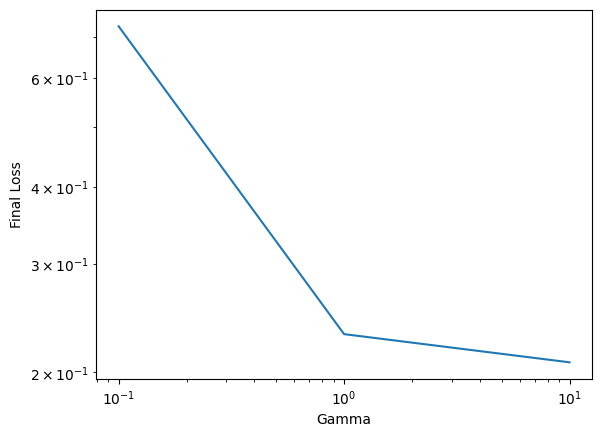

In [33]:
import matplotlib.pyplot as plt
plt.plot(np.unique(np.array(result['jobs'])[:, -1]), et_losses[:, :, :].mean(axis=1).flatten())
plt.xscale('log')
plt.yscale('log')
plt.xlabel("Gamma")
plt.ylabel("Final Loss")